## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
    # print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [7]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 24*24),
            nn.ReLU(),
            nn.Linear(24*24, 20*20),
            nn.ReLU(),
            nn.Linear(20*20, 15*15),
            nn.ReLU(),
            nn.Linear(15*15, num_classes),
        )
        
    def forward(self, inp):       
        return self.model(inp)

In [8]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 576]         452,160
              ReLU-3                  [-1, 576]               0
            Linear-4                  [-1, 400]         230,800
              ReLU-5                  [-1, 400]               0
            Linear-6                  [-1, 225]          90,225
              ReLU-7                  [-1, 225]               0
            Linear-8                   [-1, 10]           2,260
Total params: 775,445
Trainable params: 775,445
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.96
Estimated Total Size (MB): 2.99
----------------------------------------------------------------


Your experiments come here:

In [11]:
# Your experiments, training and validation loops here
def try_model(num_epochs, model, opt, loss_func):
    train_accuracies = []
    test_accuracies = []
    for epoch in range(num_epochs + 1):
        model.train()

        train_predicted = 0
        test_predicted = 0

        for images, labels in train_loader:
            outputs = model(images.to(device))
            labels = labels.to(device)

            loss = loss_func(outputs, labels)
            loss.backward()
            opt.step()
            opt.zero_grad()

            train_predicted += (torch.max(outputs, 1)[1] == labels).sum().item()

        model.eval()

        for images, labels in test_loader:
            outputs = model(images.to(device))
            labels = labels.to(device)

            test_predicted += (torch.max(outputs, 1)[1] == labels).sum().item()

        train_accuracy = train_predicted / len(fmnist_dataset_train)
        test_accuracy = test_predicted / len(fmnist_dataset_test)

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        if epoch % 10 == 0:
            print(f"{epoch:03d}/{num_epochs}", f"Train accuracy: {train_accuracy:.5f} Test accuracy: {test_accuracy:.5f}")
    
    return train_accuracies, test_accuracies

In [12]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.SGD(model.parameters(), lr=1e-2) # YOUR CODE HERE
loss_func = nn.CrossEntropyLoss() # YOUR CODE HERE
num_epochs = 100

tiny_train_accuracies, tiny_test_accuracies = try_model(num_epochs, model, opt, loss_func)

000/100 Train accuracy: 0.30552 Test accuracy: 0.46980
010/100 Train accuracy: 0.83157 Test accuracy: 0.80380
020/100 Train accuracy: 0.85840 Test accuracy: 0.84450
030/100 Train accuracy: 0.87200 Test accuracy: 0.85150
040/100 Train accuracy: 0.88192 Test accuracy: 0.86460
050/100 Train accuracy: 0.89133 Test accuracy: 0.87330
060/100 Train accuracy: 0.90057 Test accuracy: 0.86420
070/100 Train accuracy: 0.90862 Test accuracy: 0.88010
080/100 Train accuracy: 0.91667 Test accuracy: 0.87470
090/100 Train accuracy: 0.92337 Test accuracy: 0.88460
100/100 Train accuracy: 0.92870 Test accuracy: 0.88890


**(на случай, если output сотрется)**

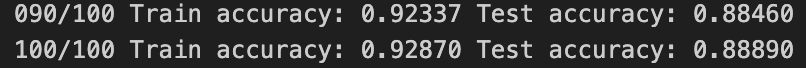

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [13]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            # Increase network complexity here (e.g., add more linear layers)
            nn.Linear(input_shape, 25*25),
            nn.ReLU(),
            nn.Linear(25*25, 22*22),
            nn.ReLU(),
            nn.Linear(22*22, 19*19),
            nn.ReLU(),
            nn.Linear(19*19, 16*16),
            nn.ReLU(),
            nn.Linear(16*16, num_classes),
        )
        
    def forward(self, inp):       
        return self.model(inp)

In [14]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 625]         490,625
              ReLU-3                  [-1, 625]               0
            Linear-4                  [-1, 484]         302,984
              ReLU-5                  [-1, 484]               0
            Linear-6                  [-1, 361]         175,085
              ReLU-7                  [-1, 361]               0
            Linear-8                  [-1, 256]          92,672
              ReLU-9                  [-1, 256]               0
           Linear-10                   [-1, 10]           2,570
Total params: 1,063,936
Trainable params: 1,063,936
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 4.06
Estimat

In [15]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.SGD(model.parameters(), lr=1e-2) # YOUR CODE HERE
loss_func = nn.CrossEntropyLoss() # YOUR CODE HERE
num_epochs = 200

# Your experiments, come here
overfitted_train_accuracies, overfitted_test_accuracies = try_model(num_epochs, model, opt, loss_func)

000/200 Train accuracy: 0.25892 Test accuracy: 0.39300
010/200 Train accuracy: 0.81508 Test accuracy: 0.80790
020/200 Train accuracy: 0.85418 Test accuracy: 0.84220
030/200 Train accuracy: 0.87770 Test accuracy: 0.86150
040/200 Train accuracy: 0.89095 Test accuracy: 0.86690
050/200 Train accuracy: 0.90185 Test accuracy: 0.87190
060/200 Train accuracy: 0.91283 Test accuracy: 0.88220
070/200 Train accuracy: 0.92080 Test accuracy: 0.87450
080/200 Train accuracy: 0.92993 Test accuracy: 0.87900
090/200 Train accuracy: 0.93697 Test accuracy: 0.87740
100/200 Train accuracy: 0.94553 Test accuracy: 0.88770
110/200 Train accuracy: 0.94963 Test accuracy: 0.88990
120/200 Train accuracy: 0.95832 Test accuracy: 0.88900
130/200 Train accuracy: 0.95900 Test accuracy: 0.88620
140/200 Train accuracy: 0.96775 Test accuracy: 0.88760
150/200 Train accuracy: 0.97440 Test accuracy: 0.89400
160/200 Train accuracy: 0.97528 Test accuracy: 0.89270
170/200 Train accuracy: 0.96878 Test accuracy: 0.88450
180/200 Tr

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [19]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 25*25),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(25*25, 22*22),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(22*22, 19*19),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(19*19, 16*16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(16*16, num_classes),
        )
        
    def forward(self, inp):       
        return self.model(inp)

In [20]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 625]         490,625
              ReLU-3                  [-1, 625]               0
           Dropout-4                  [-1, 625]               0
            Linear-5                  [-1, 484]         302,984
              ReLU-6                  [-1, 484]               0
           Dropout-7                  [-1, 484]               0
            Linear-8                  [-1, 361]         175,085
              ReLU-9                  [-1, 361]               0
          Dropout-10                  [-1, 361]               0
           Linear-11                  [-1, 256]          92,672
             ReLU-12                  [-1, 256]               0
          Dropout-13                  [-1, 256]               0
           Linear-14                   

In [22]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.SGD(model.parameters(), lr=1e-2) # YOUR CODE HERE
loss_func = nn.CrossEntropyLoss() # YOUR CODE HERE
num_epochs = 100

# Your experiments, come here
fixed_train_accuracies, fixed_test_accuracies = try_model(num_epochs, model, opt, loss_func)

000/100 Train accuracy: 0.11063 Test accuracy: 0.24560
010/100 Train accuracy: 0.69845 Test accuracy: 0.72140
020/100 Train accuracy: 0.79292 Test accuracy: 0.81290
030/100 Train accuracy: 0.83758 Test accuracy: 0.84320
040/100 Train accuracy: 0.85638 Test accuracy: 0.85950
050/100 Train accuracy: 0.86973 Test accuracy: 0.87360
060/100 Train accuracy: 0.87833 Test accuracy: 0.87680
070/100 Train accuracy: 0.88812 Test accuracy: 0.88170
080/100 Train accuracy: 0.89348 Test accuracy: 0.88230
090/100 Train accuracy: 0.89855 Test accuracy: 0.88250
100/100 Train accuracy: 0.90177 Test accuracy: 0.88460


### Conclusions:
_Write down small report with your conclusions and your ideas._

1. Благодаря 4-м линейным слоям и функциям активации ReLU после каждого слоя удалось достичь точности на тесте $\ge 0.885$.
2. С увеличением количества слоев до пяти где-то на 60-й эпохе становится заметно переобучение - точность трейна увеличивается, точность теста практически не меняется - нейросеть подстраивается под трейн датасет.
3. С помощью слоев Dropout можно совладать с переобучением нейросети - в нашем случае сработало на параметре $p=0.5$.

Возможно, обучение нейросети длится больше запланированного из-за технических проблем (слабый cpu).